### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as MAE
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#!pip install netron
#import netron  （provide a graphical representation of our hybrid model）
from random import randint

First of all, we define this function which split a given sequence into multiple samples where each sample has a specified number of time steps and a specifieded number of outputs.

In [2]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)



## Data preprocessing

We import data and remove the index. 

In [6]:
# weather_df = pd.read_csv('../../../Data/Data processing/Weather data/Dataset/weather_hourly_201801-202105.csv')
# weather_df

,site_name,lat,lon,number_of_missing_data,dates,time,humidity,visibility,weather_type,temp,wind_direction,pressure,wind_speed,wind_gust,dew_point,pressure_tendency
0,GLASGOW/BISHOPTON,55.907,-4.533,21,2018-01-22Z,21.0,88.8,15000,8,6.4,WSW,1008,14,NAN,4.7,F
1,GLASGOW/BISHOPTON,55.907,-4.533,21,2018-01-22Z,22.0,92.0,13000,7,6.3,SW,1008,9,NAN,5.1,F
2,GLASGOW/BISHOPTON,55.907,-4.533,21,2018-01-22Z,23.0,89.5,18000,7,6.8,SSW,1007,11,NAN,5.2,F
3,GLASGOW/BISHOPTON,55.907,-4.533,3,2018-01-23Z,0.0,90.0,23000,8,6.4,SSW,1007,8,NAN,4.9,F
4,GLASGOW/BISHOPTON,55.907,-4.533,3,2018-01-23Z,1.0,97.3,3500,11,6.0,S,1006,8,NAN,5.6,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27803,GLASGOW/BISHOPTON,55.907,-4.533,1,2021-05-07Z,18.0,50.8,75000,1,9.5,W,1012,10,NAN,-0.1,F
27804,GLASGOW/BISHOPTON,55.907,-4.533,1,2021-05-07Z,19.0,54.5,70000,1,9.0,NW,1013,8,NAN,0.4,F
27805,GLASGOW/BISHOPTON,55.907,-4.533,1,2021-05-07Z,20.0,61.5,70000,1,6.6,NW,1012,5,NAN,-0.2,F
27806,GLASGOW/BISHOPTON,55.907,-4.533,1,2021-05-07Z,21.0,67.8,70000,2,4.9,NW,1012,7,NAN,-0.5,F


In [10]:
data=pd.read_csv('../../New_flow/GD1351_R_predict_2019-11-20.csv')
index = data['timeStamp(t+12)']
data=data.drop(['timeStamp(t+12)'], axis=1)
data

# display(data)
# print(index)

,varFlow,time(t+12),newFlow(t+12)
0,62.0,12.00,113.0
1,62.0,12.25,113.0
2,62.0,12.50,113.0
3,62.0,12.75,113.0
4,62.0,13.00,117.0
...,...,...,...
72331,31.0,22.75,40.0
72332,53.0,23.00,48.0
72333,66.0,23.25,53.0
72334,44.0,23.50,35.0


We encode the categorical variable 'type of day'.

In [5]:
encoder = LabelEncoder()
data[data.columns[7]] = encoder.fit_transform(data[data.columns[7]])


We normalise all input variables. 

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data[data.columns.difference(['newFlow(t+12)'])] = scaler.fit_transform(data[data.columns.difference(['newFlow(t+12)'])])

In [5]:
data

,varFlow,time(t+12),newFlow(t+12)
0,0.202614,0.505263,113.0
1,0.202614,0.515789,113.0
2,0.202614,0.526316,113.0
3,0.202614,0.536842,113.0
4,0.202614,0.547368,117.0
...,...,...,...
72331,0.101307,0.957895,40.0
72332,0.173203,0.968421,48.0
72333,0.215686,0.978947,53.0
72334,0.143791,0.989474,35.0


We apply the previously defined function. We split the original sequence data. Each sample has four time steps as predictor variables (from timestep t-15 to timestep t-12) and one target variable (timestep t). 

In [6]:
data1=data.values
X, y = split_sequences(data1,4,1)

## Data analyse

We make a simple statistical analysis of the target variable. 

In [7]:
dataplot = data
dataplot['newFlow(t+12)'].describe()

count    72336.000000
mean        53.338621
std         32.365963
min          0.000000
25%         26.000000
50%         49.000000
75%         75.000000
max        306.000000
Name: newFlow(t+12), dtype: float64

We plot linechart of the evolution of traffic flow in the first week from 2019-11-20 (first available data). 

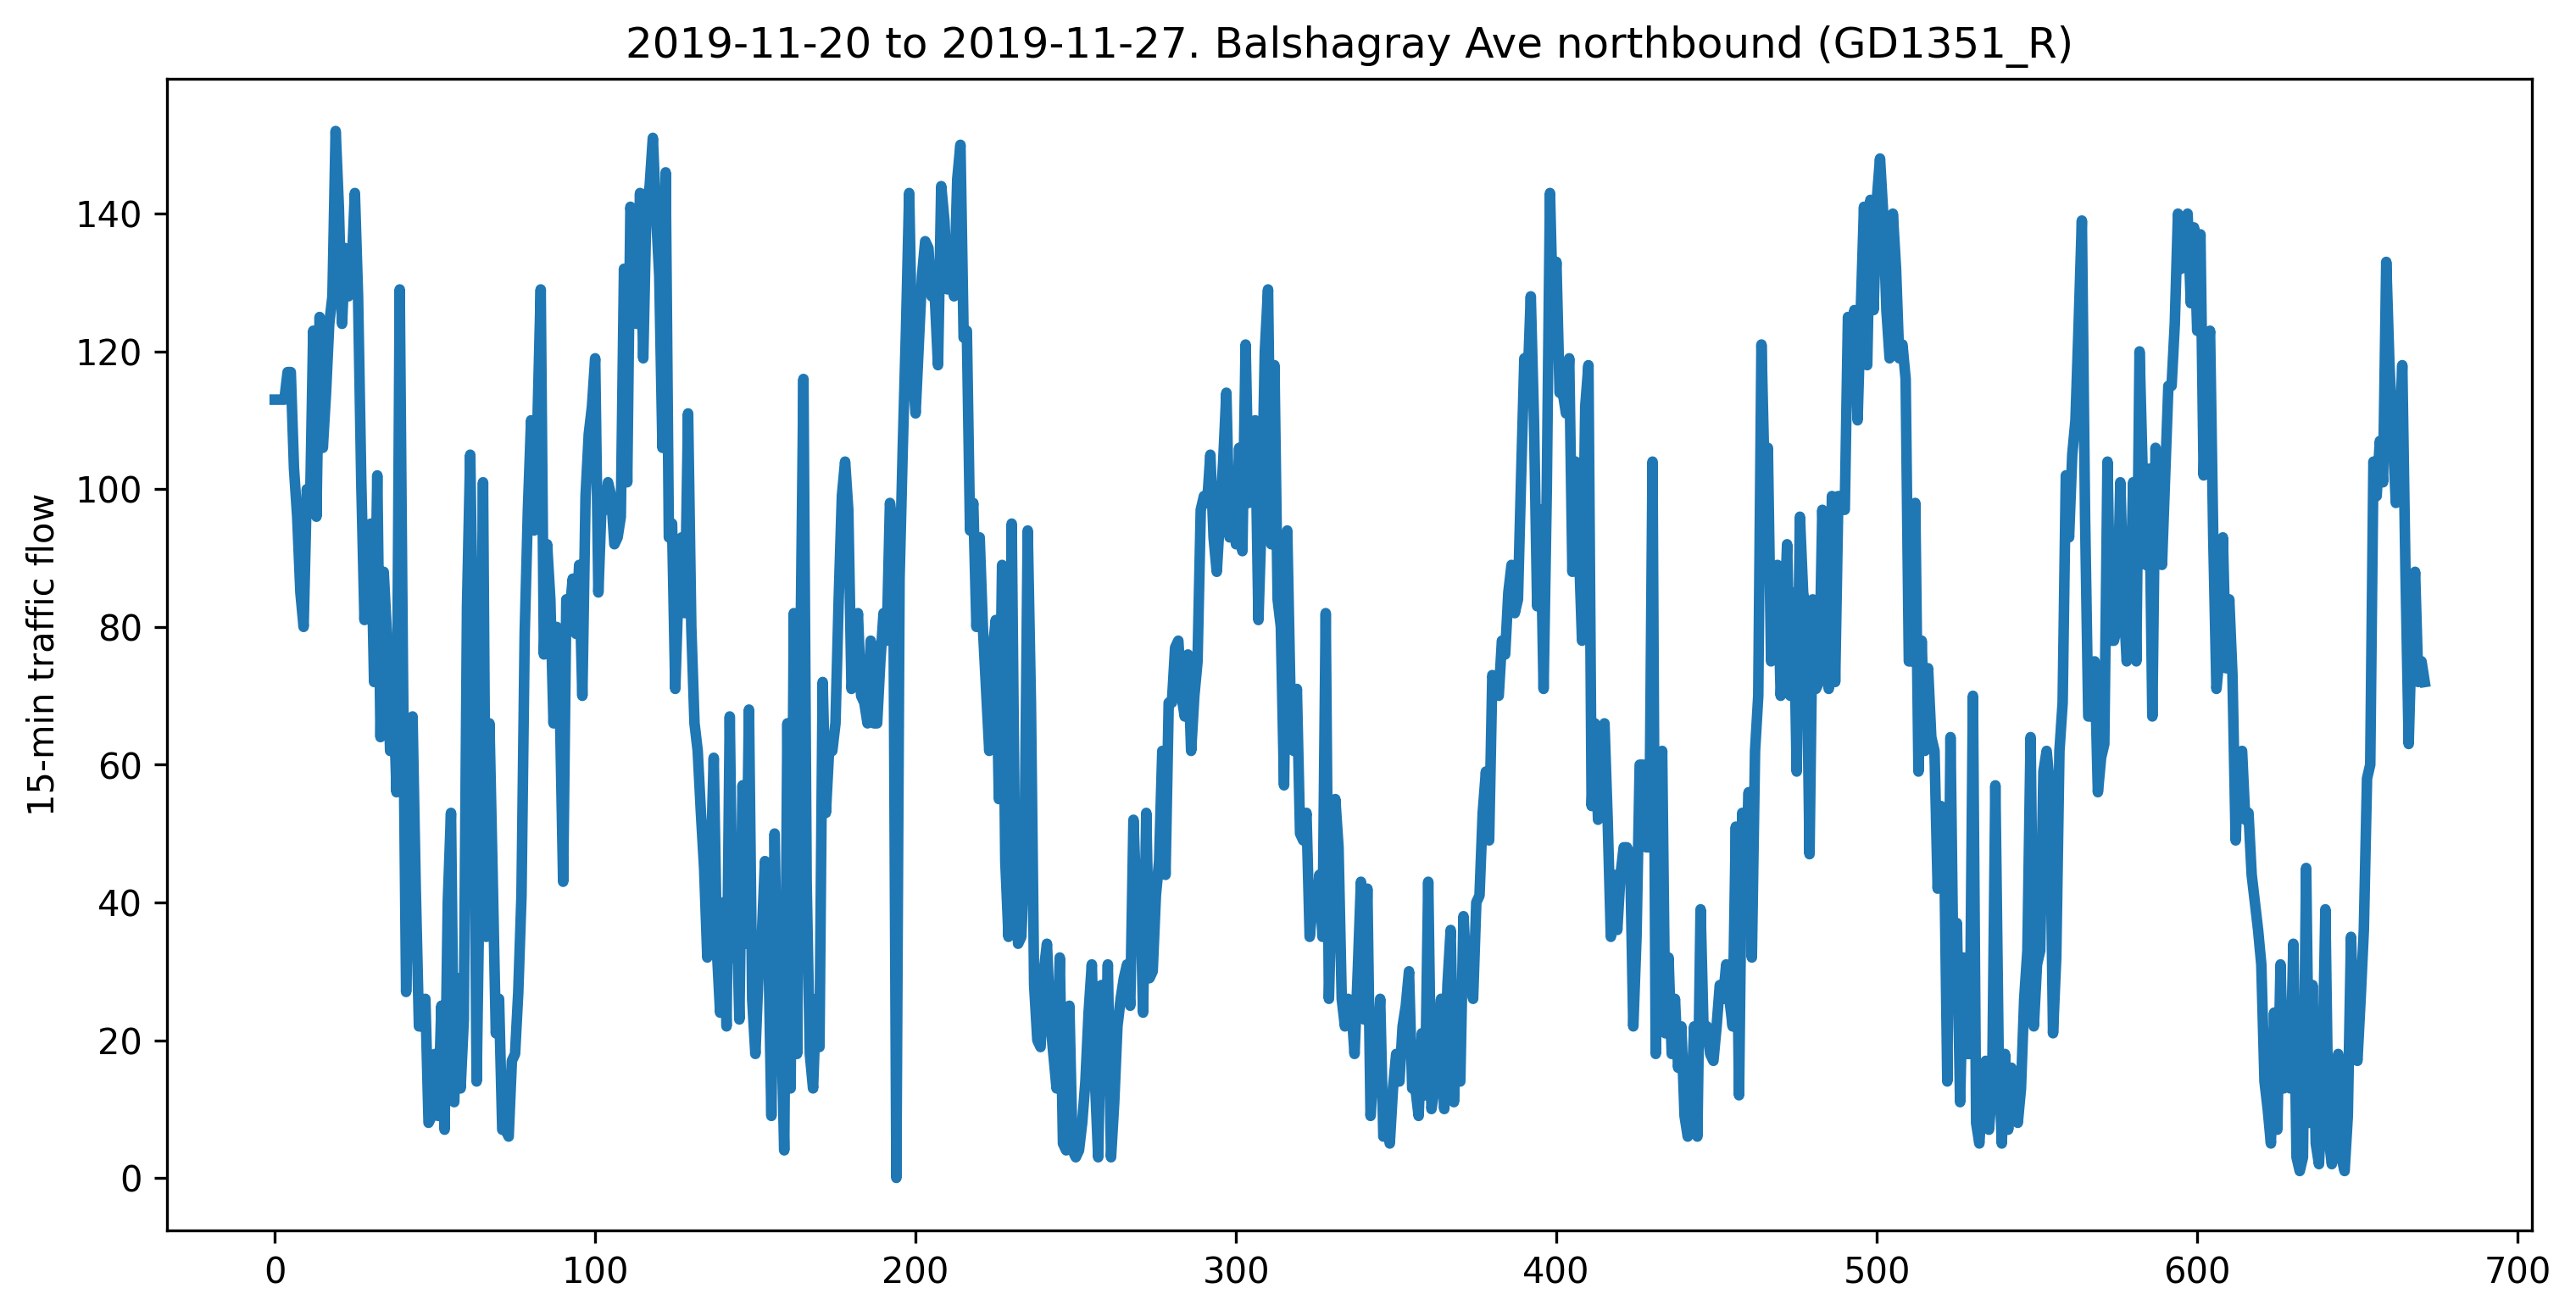

In [11]:
from matplotlib.pyplot import figure
figure(figsize=(12, 6), dpi=300)
plt.plot(list(dataplot['newFlow(t+12)'][0:96*7]),
        label=index, linewidth=3)
plt.title('2019-11-20 to 2019-11-27. Balshagray Ave northbound (GD1351_R)')
plt.ylabel('15-min traffic flow')
plt.show()

## Model development. 

We reshape our data to have the structure required by the neural network. 

In [12]:
X = X.reshape((X.shape[0], X.shape[1], X.shape[2])).astype('float32')
y = y.reshape((y.shape[0], y.shape[1])).astype('float32')

We divide randomly our data in the train and test sets. 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

In [14]:
X_train.shape
#y.shape

(48463, 4, 2)

We develop our model by using keras and tensorflow. First, we apply a convolutional neural network with 256 kernels which is followed by a max pooling. Then, we flatten data. 

Subsequently, we use the flatten data as input in the Bidirectional long short term memory network, with 500 units. It is followed by a dropout layer and, finally, we apply a dense layer to obtain the required prediction. 

In [16]:
model3 = Sequential()
model3.add(TimeDistributed(Conv1D(filters=256, kernel_size=1, activation='relu'), input_shape=(4,2,1)))
model3.add(TimeDistributed(MaxPooling1D(pool_size=1, padding='same')))
model3.add(TimeDistributed(Flatten()))
model3.add(Bidirectional(LSTM(500, activation = 'relu')))
model3.add(Dropout(0.5))
model3.add(Dense(1))
model3.compile(optimizer = 'adam', loss = 'mae')

We provide a graphical representation of the model by using Netron. Reader can deeply analyse each layer of the model. 

In [29]:
model3.save('model.h5')
#netron.start('model.h5')

We train the model.

In [17]:
history3=model3.fit(X_train,y_train,epochs=100, batch_size = 64, shuffle=True,validation_data=(X_test,y_test))

Epoch 1/100
758/758 [==============================] - 95s 122ms/step - loss: 22.1175 - val_loss: 17.5298
Epoch 2/100
758/758 [==============================] - 93s 123ms/step - loss: 17.7579 - val_loss: 16.9322
Epoch 3/100
758/758 [==============================] - 94s 124ms/step - loss: 17.6113 - val_loss: 16.6767
Epoch 4/100
758/758 [==============================] - 95s 126ms/step - loss: 17.2982 - val_loss: 16.8202
Epoch 5/100
758/758 [==============================] - 98s 130ms/step - loss: 17.2264 - val_loss: 17.0125
Epoch 6/100
758/758 [==============================] - 97s 128ms/step - loss: 17.2416 - val_loss: 16.8944
Epoch 7/100
758/758 [==============================] - 97s 128ms/step - loss: 17.1392 - val_loss: 16.5377
Epoch 8/100
758/758 [==============================] - 99s 130ms/step - loss: 17.0711 - val_loss: 16.7544
Epoch 9/100
758/758 [==============================] - 101s 134ms/step - loss: 17.0262 - val_loss: 16.8139
Epoch 10/100
758/758 [=======================

## Model evaluation

We define this function, which will be useful to evaluate the model.

In [18]:
def flatten(t):
    return [item for sublist in t for item in sublist]

We evaluate the model by using the first metric (mean absolute error). 

In [19]:
pred = model3.predict(X_test)
MAE = MAE(flatten(pred),flatten(y_test))
print(MAE)

15.949497


We will evaluate the model with the second metric (accuracy). For this, we divide target variable in three categories: first, data between percentil 0 and 15; second, data between percentil 15 and 85 and thrid, data between percentil 85 and 100. 

In [20]:
obj = list(data['newFlow(t+12)'].values)

In [21]:
print(np.quantile(obj, 0))
print(np.quantile(obj, 0.15))
print(np.quantile(obj, 0.85))
print(np.quantile(obj, 1))

0.0
18.0
88.0
306.0


We add and substract a small value in extreme values in order to avoid issues. We also transform the predictions lower than 0 in 0. 

In [22]:
bins = [np.quantile(obj, 0)-0.001,np.quantile(obj, 0.15),np.quantile(obj, 0.85),np.quantile(obj, 1)+0.001]
names = ['a','b','c']
for i in range(len(pred)):
    if pred[i]<0:
        pred[i] = 0
pred2=pd.cut(flatten(pred), bins, labels = names)
ytest2=pd.cut(flatten(y_test), bins, labels = names)

We obtain the accuracy metric and the confusion matrix corresponding. 

In [23]:
print(accuracy_score(ytest2,pred2))
print(confusion_matrix(ytest2,pred2))

0.7388772517804776
[[  995  2738     4]
 [  570 15422   682]
 [   22  2217  1220]]


###  Plotting the actual and predicted values. 

We selelct randomly an observation of the entire dataset and we will analyse the 100 successive observations. We plot
the actual and the predicted values of these observations. 

In [25]:
y.shape

(72333, 1)

In [44]:
rand = randint(0, 72000)
rand

60492

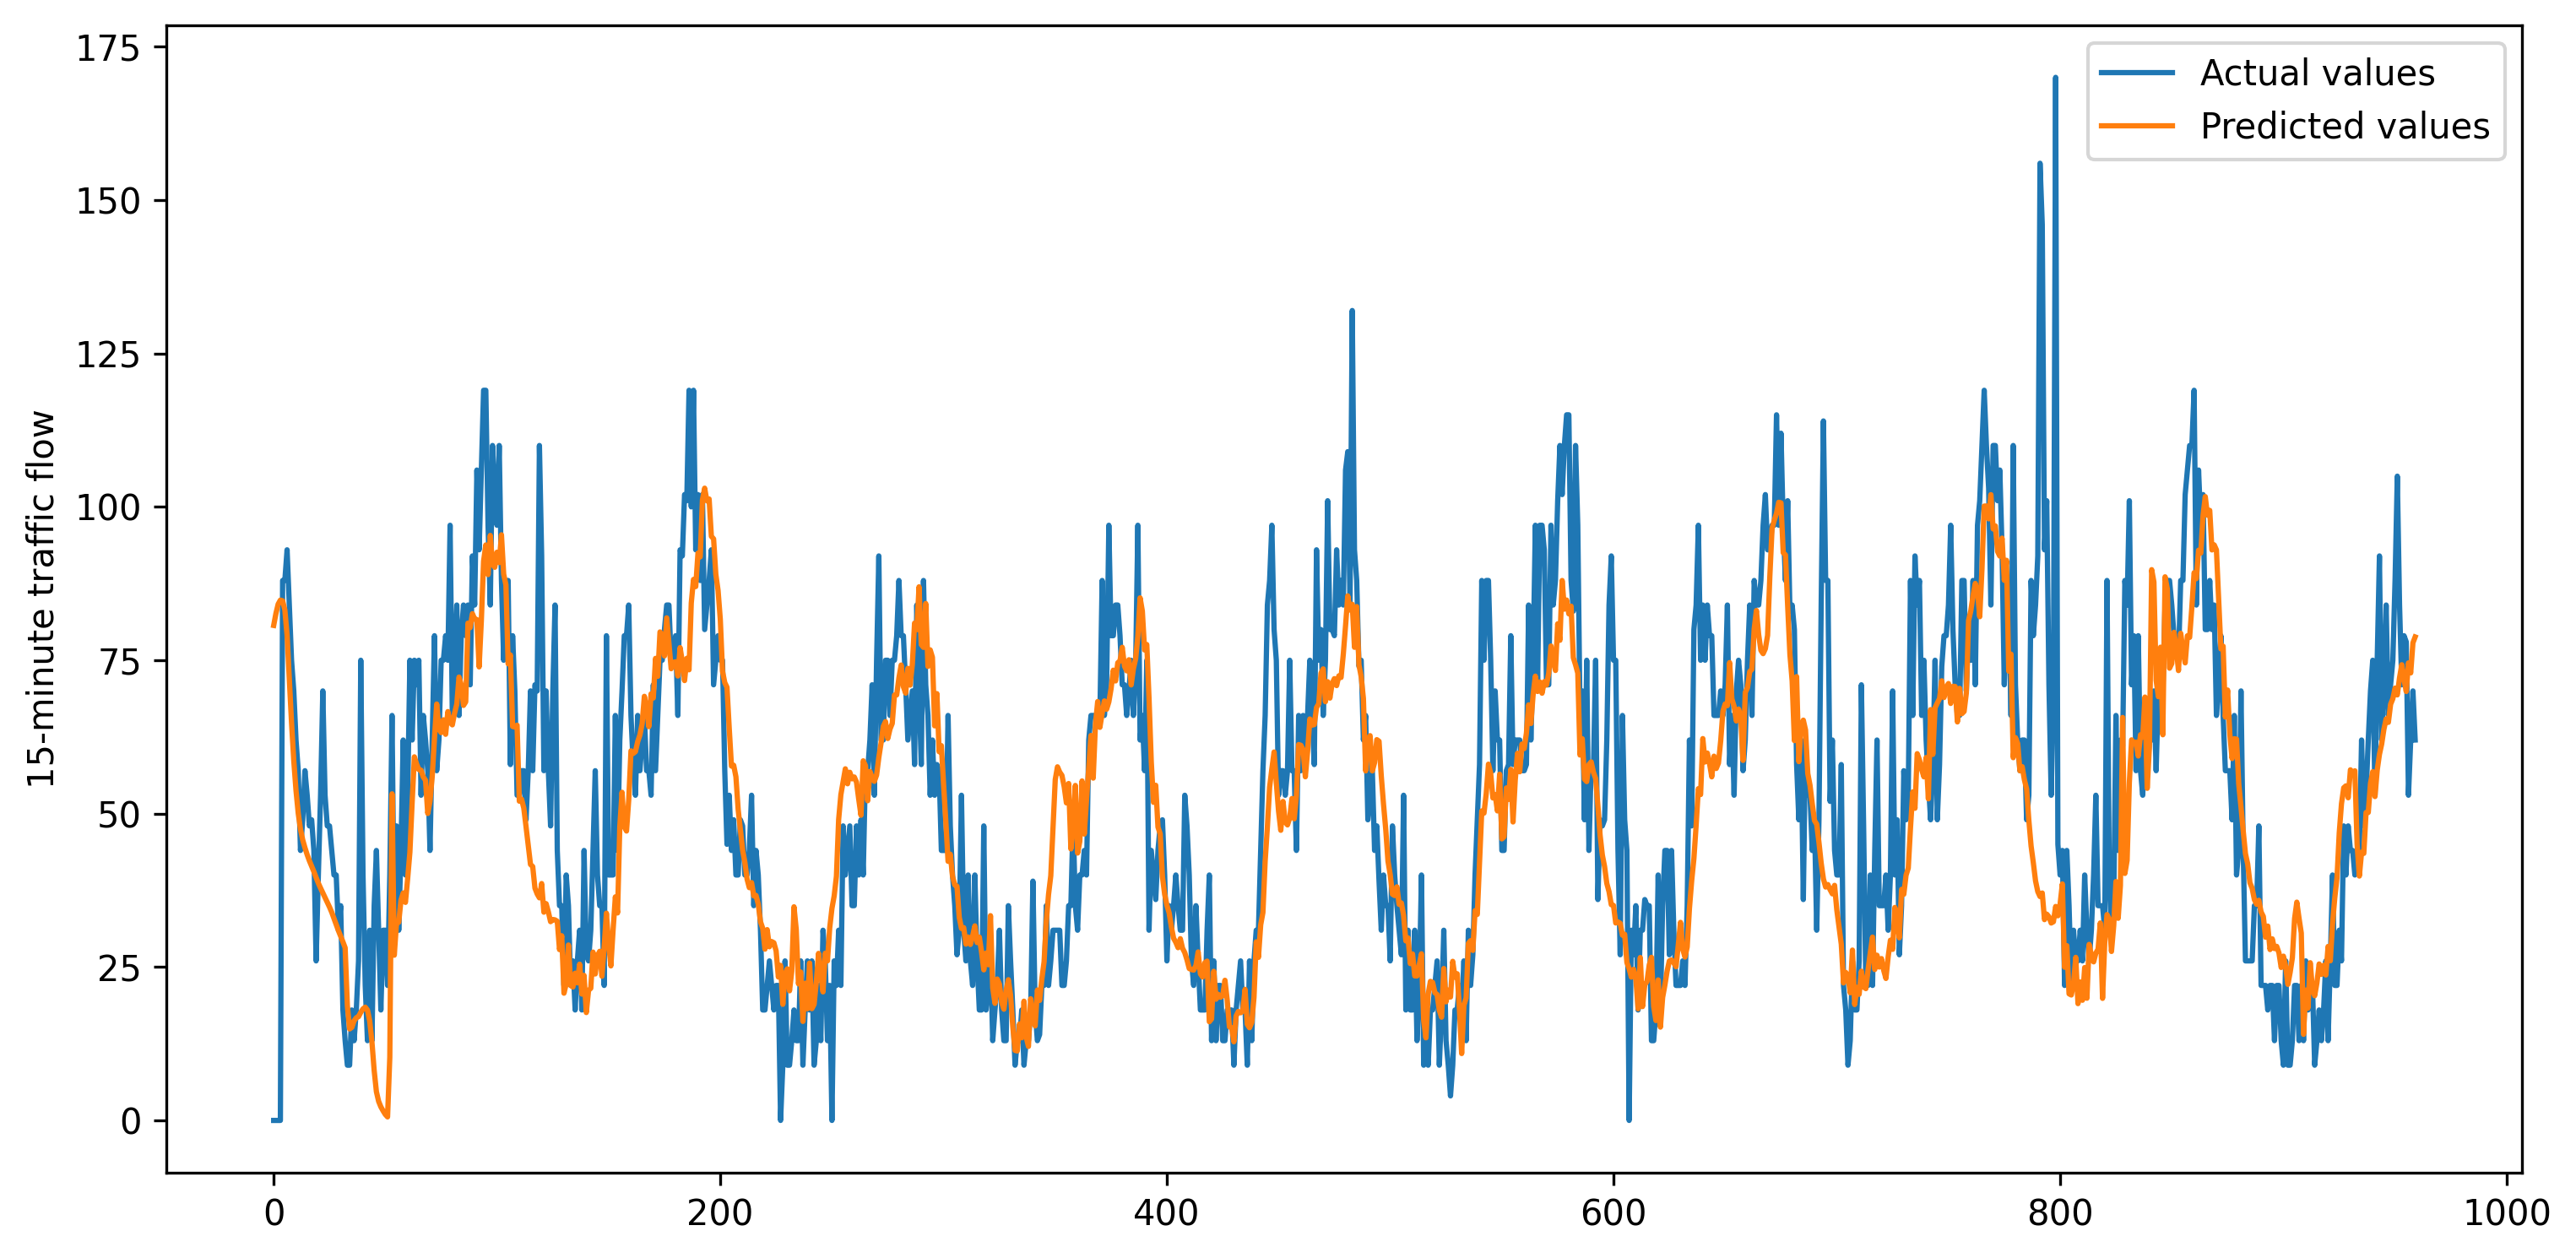

In [45]:
figure(figsize=(12, 6), dpi=300)
plt.plot(flatten(y[rand:rand+960]), label = "Actual values")
plt.plot(flatten(model3.predict(X[rand:rand+960])), label = "Predicted values")
plt.legend()
plt.ylabel('15-minute traffic flow')
plt.show()